In [8]:
import pandas as pd 
import numpy as np 
import os 

## Generate Dataframe

In [9]:
DATASET_DIR = os.path.join(os.getcwd(), "..", "data", "images", "Dataset")

def get_dir_path(image_category: str, image_class: str):
  # image_category : {"Test", "Train", "Valid"}
  # image_class : {"Fake", "Real"}
  return os.path.join(DATASET_DIR, image_category.title(), image_class.title())

In [10]:
# Random pick for image to be used
amount_train = 2000
amount_test = 400 
# amount_valid = 400

bound_test = 1000
# bound_valid = 1000
bound_train = 5000


import random

# Create a little imbalance for test data
test_real_amount = random.randint(round(0.375*amount_test), round(0.625*amount_test))
test_fake_amount = amount_test - test_real_amount
test_real_id = random.sample(range(1, bound_test), test_real_amount)
test_fake_id = random.sample(range(1, bound_test), test_fake_amount)

# Balanced data for train data
train_real_amount = train_fake_amount = amount_train//2
train_real_id = random.sample(range(1, bound_train), train_real_amount)
train_fake_id = random.sample(range(1, bound_train), train_fake_amount)

# Create a little imbalance for valid data
# valid_real_amount = random.randint(round(0.4*amount_valid), round(0.6*amount_valid))
# valid_fake_amount = amount_valid - valid_real_amount
# valid_real_id = random.sample(range(1, bound_valid), valid_real_amount)
# valid_fake_id = random.sample(range(1, bound_valid), valid_fake_amount)

In [11]:
# Make dataframe consist of: {path, label}

def make_df(category: str, images_list_real:list, images_list_fake: list):
  # category : {"Test", "Train", "Valid"}
  fake_dir = get_dir_path(category, "Fake")
  real_dir = get_dir_path(category, "Real")

  data = []
  for img_name in images_list_real:
    img_path = os.path.join(real_dir, f"real_{img_name}.jpg")
    temp_data = {"path": img_path, "label": 0}
    data.append(temp_data)

  for img_name in images_list_fake:
    img_path = os.path.join(fake_dir, f"fake_{img_name}.jpg")
    temp_data = {"path": img_path, "label": 1}
    data.append(temp_data)

  random.shuffle(data)

  return pd.DataFrame(data)

df_test = make_df("Test", test_real_id, test_fake_id)
df_train = make_df("Train", train_real_id, train_fake_id)
# df_valid = make_df("Valid", valid_real_id, valid_fake_id)

df_test.to_csv(os.path.join("csv", "test.csv"), index=False)
df_train.to_csv(os.path.join("csv", "train.csv"), index=False)
# df_valid.to_csv(os.path.join("csv", "valid.csv"), index=False)

## Preparation

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
df_train = pd.read_csv(os.path.join(".", "csv", "train.csv"))
df_test = pd.read_csv(os.path.join(".", "csv", "test.csv"))

In [ ]:
image_paths = df_train['path'].values
labels = df_train['label'].values

test_image_paths = df_test['path'].values
test_labels = df_test['label'].values


# Parameters
IMG_SIZE = 128  # Resize images to 128x128
BATCH_SIZE = 32


# PROCESS TRAIN
# Preprocessing function
def preprocess_image(img_path, label):
    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    image = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Load and preprocess the dataset
images = []
for img_path, label in zip(image_paths, labels):
    try:
        img, lbl = preprocess_image(img_path, label)
        images.append((img, lbl))
    except Exception as e:
        print(f"Error loading train image {img_path}: {e}")

# Split into features and labels
X, y = zip(*images)
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)


# PROCESS TEST
test_images = []
for img_path, label in zip(test_image_paths, test_labels):
    try:
        img, lbl = preprocess_image(img_path, label)
        test_images.append((img, lbl))
    except Exception as e:
        print(f"Error loading test image {img_path}: {e}")

# Split into features and labels
X_test, y_test = zip(*test_images)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

In [ ]:
# Convert features and labels into numpy arrays
X = np.array(X)  # List of images to numpy array
y = np.array(y)  # List of labels to numpy array

X_test = np.array(X_test)
y_test = np.array(y_test)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import GridSearchCV

In [16]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1
)


d:\Program Files\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Program Files\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.4872 - loss: 2.7576 - val_accuracy: 0.4925 - val_loss: 1.8684
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 462ms/step - accuracy: 0.5605 - loss: 0.7077 - val_accuracy: 0.5375 - val_loss: 1.0284
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - accuracy: 0.5857 - loss: 0.6659 - val_accuracy: 0.5350 - val_loss: 0.8036
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step - accuracy: 0.5928 - loss: 0.6715 - val_accuracy: 0.5825 - val_loss: 0.7001
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 443ms/step - accuracy: 0.6196 - loss: 0.6680 - val_accuracy: 0.4925 - val_loss: 1.1459
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.6085 - loss: 0.6601 - val_accuracy: 0.6200 - val_loss: 0.6870
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - accuracy: 0.6075 - loss: 0.6609 - val_accuracy: 0.6300 - val_loss: 0.6922
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 493ms/step - accuracy: 0.6202 - loss: 0.6631 - val_accu

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,916,101 (37.83 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 6,610,436 (25.22 MB)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.77      0.62      0.69       239
    Fake (1)       0.56      0.73      0.64       161

    accuracy                           0.66       400
   macro avg       0.67      0.67      0.66       400
weighted avg       0.69      0.66      0.67       400



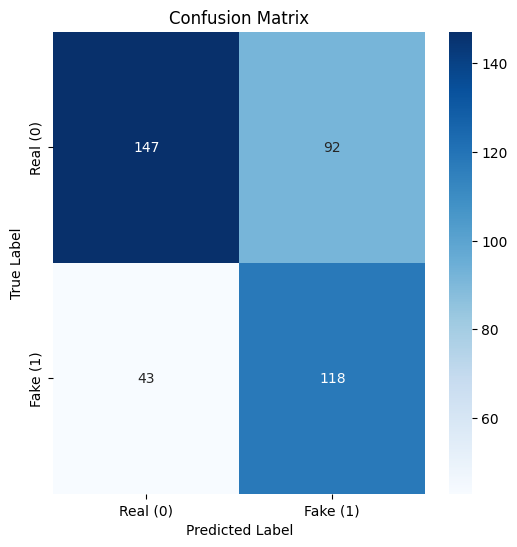

In [25]:
# Make predictions
y_pred = model.predict(X_test)  # Predict probabilities
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=["Real (0)", "Fake (1)"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Real (0)", "Fake (1)"], yticklabels=["Real (0)", "Fake (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Save model
model.save(os.path.join("model", "CNN.h5"))

# How to load model
# loaded_model = tf.keras.models.load_model('model/CNN.h5')

## GAN

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
import numpy as np

In [32]:
# Set dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
LATENT_DIM = 100  # Size of random noise vector for the generator

# Generator
def build_generator():
    model = Sequential([
        Dense(8 * 8 * 256, input_dim=LATENT_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((8, 8, 256)),

        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding='same', activation='tanh')
    ])
    return model

# Discriminator
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Conv2D(256, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

# Build GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False  # Freeze discriminator while training the generator
    
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')
    return gan

# Create models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Print summaries
generator.summary()
discriminator.summary()
gan.summary()


d:\Program Files\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Program Files\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
d:\Program Files\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,344,675 (8.94 MB)

 Trainable params: 2,344,675 (8.94 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        65,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,417 (2.76 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 724,417 (2.76 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │     2,344,675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 1)              │       724,417 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,069,092 (11.71 MB)

 Trainable params: 2,344,675 (8.94 MB)

 Non-trainable params: 724,417 (2.76 MB)

In [49]:
# Training function
def train_gan(generator, discriminator, gan, real_images, labels, epochs=100, batch_size=64):
    batch_count = real_images.shape[0] // batch_size
    half_batch = batch_size // 2

    for epoch in range(epochs):
        for _ in range(batch_count):
            # Train Discriminator
            # ------------------
            # Generate fake images
            noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
            fake_images = generator.predict(noise)

            # Get real images
            idx = np.random.randint(0, real_images.shape[0], half_batch)
            real_imgs = real_images[idx]

            # Labels for real and fake images
            real_labels = np.zeros((half_batch, 1))  # Real images should have label 0
            fake_labels = np.ones((half_batch, 1))  # Fake images should have label 1


            # Train discriminator on real and fake images
            d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            # ----------------
            noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
            valid_labels = np.ones((batch_size, 1))  # Generator wants fake images to be classified as real (label 1)
            g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress
        print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss[0]:.4f}, D Acc: {100 * d_loss[1]:.2f}% | G Loss: {g_loss:.4f}")

# Train GAN
train_gan(generator, discriminator, gan, X_train, y_train, epochs=20, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'